In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
from scipy import stats
rcParams['figure.figsize'] = 8, 5
np.warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('nbastats2018-2019.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 27 columns):
Name        521 non-null object
Height      521 non-null int64
Weight      521 non-null int64
Team        470 non-null object
Age         521 non-null int64
Salary      521 non-null object
Points      521 non-null float64
Blocks      521 non-null float64
Steals      521 non-null float64
Assists     521 non-null float64
Rebounds    521 non-null float64
FT%         499 non-null float64
FTA         521 non-null float64
FG3%        489 non-null float64
FG3A        521 non-null float64
FG%         519 non-null float64
FGA         521 non-null float64
MP          521 non-null float64
G           521 non-null int64
PER         521 non-null float64
OWS         521 non-null float64
DWS         521 non-null float64
WS          521 non-null float64
WS48        521 non-null float64
USG         521 non-null float64
BPM         521 non-null float64
VORP        521 non-null float64
dtypes: float64

Выше представлен датасет включающий в себя данные об игроках и их показателях в сезоне 2018-2019. Проанализируем его для выявления связей между отдельными показателями игрока и его средними очками за игру, а так же для выявления ключевых факторов влияющих на исход матча.


__Аббревиатуры:__

FT% - Free Throw Percentage

FTA - Free Throw Attempts

FG3% - Three Point Percentage

FG3A - Three Pointer Attempts

FG% - Field Goal Percentage

FGA - Field Goal Attempts

MP - Minutes Played

G - Games

PER - Player Efficiency Rating

OWS - Offensive Win Shares

DWS - Defensive Win Shares

WS - Win Shares

WS48 - Win Shares Per 48 Minutes

USG - Usage Percentage

BPM - Box Plus-Minus

VORP - Value Over Replacement Player


##### Для начала посмотрим на корреляции нескольких ключевых показателей:

In [4]:
corr_matrix = df[["Points", "Blocks", "Steals", "Assists", "FG%", "Rebounds", "WS", "PER", "Height"]].corr()

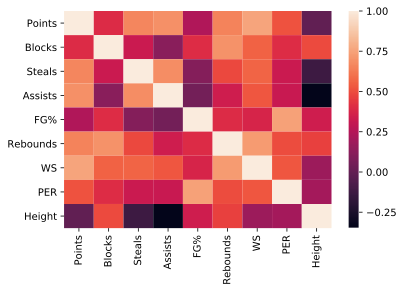

In [5]:
sns.heatmap(corr_matrix)

Как мы видим, между набранными очками, передачими и кражей мяча есть корреляционная зависимость, а так же между набранными очками и подборами. При чем стоит заметить, что процент попадания игрока практически __не имеет зависимости с набранными очками__, однако _PER_(рейтинг полезности игрока) больше зависит от его процента попаданий, чем от набранных очков.  

Так же видим, что на благоприятный исход матча сильно влияют практически все показатели, кроме роста и процента попадания.

Рост коррелирует лишь с блоками и подборами.


In [6]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

###### Теперь посмотрим на распределения всех интересующих нас количественных признаков. На бинарные/категориальные/порядковые признакие будем смотреть отдельно.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027853EEBA90>,
      dtype=object)

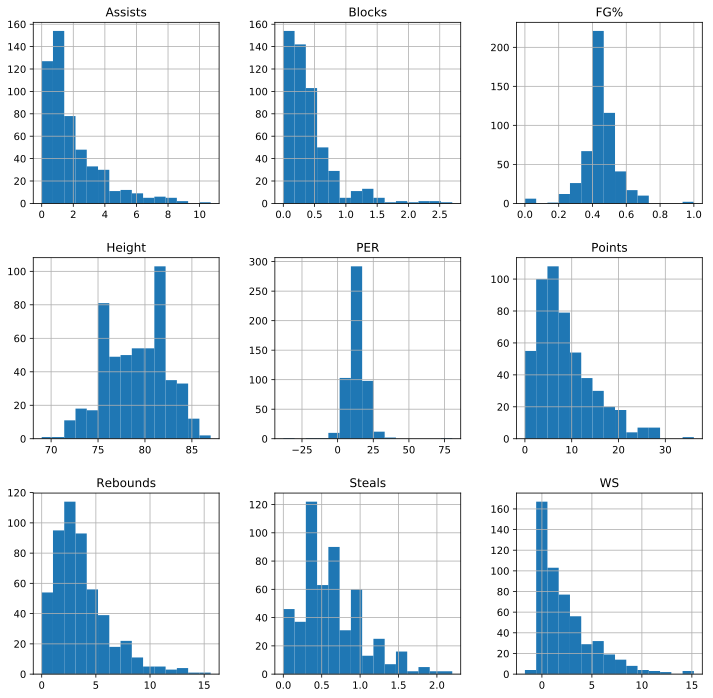

In [7]:
features = ["Points", "Blocks", "Steals", "Assists", "FG%", "Rebounds", "WS", "PER", "Height"]
df[features].hist(figsize=(12,12), bins=15)

Видим, что распределение близко к нормальному лишь у _PER_(рейтинг полезности игрока) и _FG%_(процент попаданий)

Графики _асистов, блоков, набранных очков, подборов, и побед_ больше напоминают нам __распределение Пуассона__

__Изучим детальнее взаимодействие каждой пары признаков__

На главной диагонали находятся распределения признаков, а вне главной диагонали – диаграммы рассеяния для пар признаков

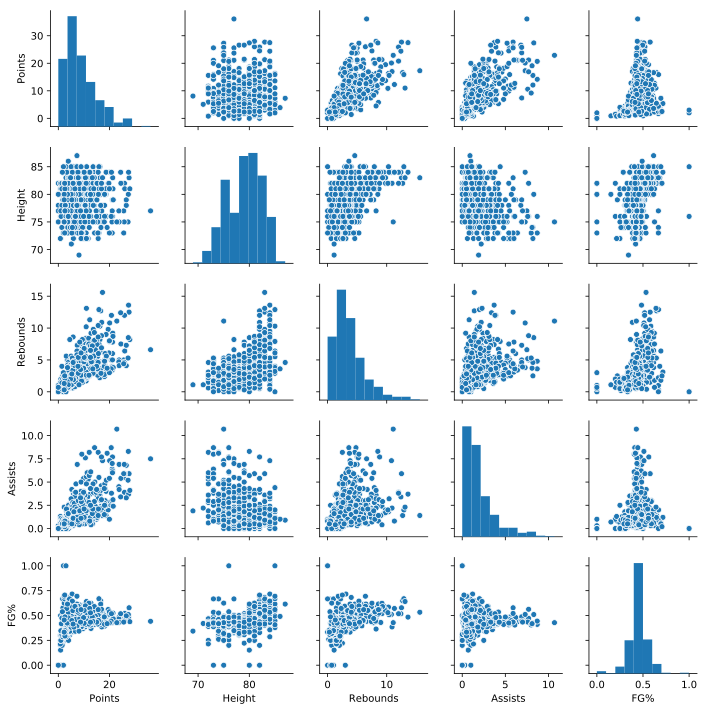

In [8]:
features_ = ["Points", "Height", "Rebounds", "Assists", "FG%"]
sns.pairplot(df[features_], height=2)

Теперь посмотрим на распределения зарплат игроков, но сначала избавимся от пропусков в данных заполнив их средний значанием по зарплате.

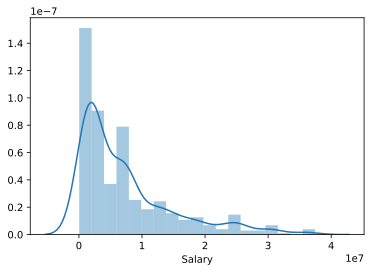

In [9]:
df.loc[df['Salary'].isnull(), 'Salary'] = df["Salary"].mean()
sns.distplot(df["Salary"])

Распределение зарплат, так же больше похоже на _распределение Пауссона_

Посмотрим на связь между зарплатой и количеством забитых очков:

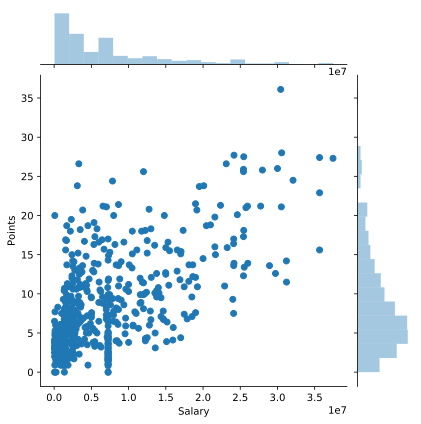

In [10]:
sns.jointplot(df["Salary"], df["Points"])

In [11]:
np.corrcoef(df["Salary"], df["Points"])

array([[1.        , 0.60348687],
       [0.60348687, 1.        ]])

График и коэффициент корреляции показывают нам _среднюю_ зависимость между этими двуми величинами.

### Выше игрок больше очков?

Давайте проверим, есть ли связь между ростом игрока и его средним кол-вом очков за игру. 

Проверим гипотезу $H_0$ о том, что рост __не влияет__ на количество набранных очков. Для этого сделаем две выборки, одна будет содержать средние значения очков за игру для игроков ростом до 195 см, а вторая будет содержать данные игроков выше 195 см.
Заметим, что в данном датасете рост указан в дюймах, поэтому для фильтрации мы будем использовать тоже дюймы, наш порог 195 см равняется __76.7__ дюймам.

__Для проверки этой гипотезы воспользуемся однофакторным дисперсионным анализом__

In [12]:
df_short = df.loc[df["Height"] < 76.7, 'Points']
df_tall = df.loc[df["Height"] > 76.7, 'Points']

n1 = df_short.shape[0]
n2 = df_tall.shape[0]
n1, n2

(129, 392)

In [13]:
short_mean = df_short.mean()
tall_mean = df_tall.mean()
short_mean, tall_mean

(9.303875968992248, 8.55076530612245)

Так как средние значения разнятся проверим статистическую значимость этого отличия.

In [14]:
y = np.concatenate([df_short, df_tall])
y_mean = y.mean()
y_mean

8.737236084452976

Найдём значения $S_F^2$ и $S_{res}^2$:

In [15]:
S2_F = n1 * (short_mean - y_mean) ** 2 + n2 * (tall_mean - y_mean) ** 2
S2_res = ((df_short - short_mean) ** 2).sum() + ((df_tall - tall_mean) ** 2).sum()
S2_F, S2_res

(55.04978753794494, 19202.647832423667)

Проверим выполнение равенства $S^2 = S_F^2 + S_{res}^2:$

In [16]:
S2_F + S2_res == ((y - y_mean) ** 2).sum()

True

Запишем оценки дисперсий:

In [17]:
k = 2
n = n1 + n2

k1 = k - 1
k2 = n - k

sigma2_F = S2_F / k1
sigma2_res = S2_res / k2

sigma2_F, sigma2_res

(55.04978753794494, 36.999321449756586)

Итак, значение статистики $T$:

$$T = \dfrac{\sigma_F^2}{\sigma_{res}^2}.$$

In [18]:
T = sigma2_F / sigma2_res
T

1.4878593817646109

Зафиксируем уровень значимости $\alpha = 0.05$. Для него найдём критическое значение $F_{crit}$:

In [19]:
alpha = 0.05
F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

3.8594383595059996

Видим, что $T < F_{crit}$, поэтому заключаем, что отличие средних очков за игру между игроками разного роста __не является__ статистически значимым. Соответственно мы принимаем гипотезу $H_0$, и делаем вывод, что рост игрока действительно не влияет на количество набранных им очков.